In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
# Supress numpy scientific notation
np.set_printoptions(suppress=True)

In [ ]:
!pip install "gymnasium[toy-text]"

To import, we use the below import statement. Notice, we rename the module gymnasium to gym. This is standard practice, as the previous versions of Gymnasium were referred to as Gym. Recently, there was a major shift in maintainers, from OpenAI to Farama-Foundation. You can find out more about this major switch and the changes that it had on the API in the following [blog post](https://farama.org/Announcing-The-Farama-Foundation). For now, just be aware that the from version 0.26.2 there were some major API changes and the maintainers of the project changed.

In [ ]:
import gymnasium as gym

### Making an Environment: Frozen Lake

onment.

The goal of the Frozen Lake environment is to reach the present (i.e., the goal state) while avoiding holes. If the agent steps onto a state with a hole, the episode ends, the agent losses, and a reward of +0 is given. A positive reward of +1 is given for reaching the goal where the episode then ends.

<center><img src="https://gymnasium.farama.org/_images/frozen_lake.gif"></center>


In [ ]:
# Utility for generating a random grid (e.g., map) for Frozen Lake
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
map_size = 4 # grid size of the Frozen Lake 4x4
env = gym.make(
    'FrozenLake-v1',
    render_mode='rgb_array',
    desc=generate_random_map(
        size=map_size,
        seed=10
    ),
    is_slippery=False
)
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>>

In [ ]:
from gymnasium import spaces

#### Action Space

The Frozen Lake action space will then an instance of the `Discrete` ([docs](https://gymnasium.farama.org/api/spaces/fundamental/#discrete)) class which represents a categorical/discrete distribution. This class represents a finite subset of integers, more specifically a set of the form $\{a, a+1, ..., a + n -1\}$.

In the below code we can see the action space for Frozen Lake which has 4 actions: 0, 1, 2, and 3. As in the documents, the action space is described as follows:

    The action shape is (1,) in the range {0, 3} indicating which direction to move the player.
    
        0: Move left
    
        1: Move down
    
        2: Move right
    
        3: Move up

In [ ]:
env.action_space

Discrete(4)

If we access the `n` attribute, we can see it gives the size of the action space.

In [ ]:
n_actions = env.action_space.n

print(f"Number of actions in space: {n_actions}")

Number of actions in space: 4


If we call the `sample()` method, it will randomly select an action within the action space.

In [ ]:
env.action_space.sample()

1

#### State/Observation Space

The Frozen Lake state or observation space will also be an instance of the `Discrete` ([docs](https://gymnasium.farama.org/api/spaces/fundamental/#discrete)) class. This means the state observations are discrete and represented as integers!


In [ ]:
env.observation_space

Discrete(16)

In [ ]:
n_states = env.observation_space.n

print(f"Number of states in space: {n_states}")

Number of states in space: 16


In [ ]:
env.observation_space.sample()

14

In [ ]:
obs, info = env.reset()

In [ ]:
print(f"Observation/state:\n{obs}")

Observation/state:
0


In [ ]:
print(f"Info: {info}")

Info: {'prob': 1}


##### `step()`

Step is how we step the environment forward one time step. To do so, we simply need to pass an action. For the sake of example, we can select a random action from the action space and then step the environment forward one step.

In [ ]:
# Reset environment to start fresh
obs, info = env.reset()
# Sample a random action
random_action = env.action_space.sample()
# Step the environment using the random action
next_obs, reward, terminated, truncated, info = env.step(random_action)

You can see we `step()` returns 5 different variables.

- `next_obs` or $S_{t+1}$ is the next state or observation after taking the action (stepping the environment).
- `reward` or $R_{t+1}$ is the reward we got for taking the action.
- `terminated` is whether the environment has reached a terminal state or not.
- `truncated` is whether the environment has run out of time or reached the maximum number of allotted steps for the episode.
- `info` is metadata about the environment for that step.



In [ ]:
print(f"Observation/state: {obs}")
print(f"Next observation/state: {next_obs}")
print(f"Reward: {reward}")
print(f"Terminated: {terminated}")
print(f"Truncated: {truncated}")
print(f"Info: {info}")

Observation/state: 0
Next observation/state: 0
Reward: 0.0
Terminated: False
Truncated: False
Info: {'prob': 1.0}


Notice that `terminated` or `truncated` determine the terminal state of the environment. To see if a terminal condition has been reached and the episode has ended, we can do write the below code to set the value of `done`.

In [ ]:
done = truncated or terminated
print(f"Done: {truncated}")

Done: False


In [ ]:
# Implement Q learning training
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
np.set_printoptions(suppress=True)

n_actions = env.action_space.n
n_states = env.observation_space.n

print(f"Number of actions in space: {n_actions}")
print(f"Number of states in space: {n_states}")

# -------------------------------------------------------------------
# Utility functions for plotting Q-values and policy
# -------------------------------------------------------------------
def qtable_directions_map(qtable, map_size):
    """Converts learned Q-values into a map of arrows for the best action.

    Args:
        qtable (np.array): Array of shape (n_states, n_actions)
        map_size (int): The dimension of the grid (assumes square grid)

    Returns:
        qtable_val_max (np.array): Maximum Q-value per state reshaped as (map_size, map_size)
        qtable_directions (np.array): Array of best actions represented as arrows
    """
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # machine epsilon: to check for non-zero Q-values
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Only map an arrow if a minimal Q-value was learned
            qtable_directions[idx] = directions[val]
        else:
            qtable_directions[idx] = ''
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

def plot_q_values_map(qtable, env, map_size, frame_title=None):

    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)


    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))


    last_frame = env.render()
    ax[0].imshow(last_frame)
    ax[0].axis("off")
    ax[0].set_title("Last Step" if frame_title is None else frame_title)


    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\n(arrows represent best action)")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    plt.show()

alpha = 0.1
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 2000
max_steps_per_episode = 100

qtable = np.zeros((n_states, n_actions))


rewards_all_episodes = []
steps_all_episodes = []

for episode in range(num_episodes):
    state, info = env.reset()
    total_rewards = 0
    steps = 0


    for step in range(max_steps_per_episode):

        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(qtable[state])


        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        best_next_action = np.argmax(qtable[next_state])
        td_target = reward + gamma * qtable[next_state, best_next_action]
        td_delta = td_target - qtable[state, action]
        qtable[state, action] += alpha * td_delta


        state = next_state
        total_rewards += reward
        steps += 1

        if done:
            break


    epsilon = max(epsilon * epsilon_decay, epsilon_min)


    rewards_all_episodes.append(total_rewards)
    steps_all_episodes.append(steps)


    if (episode + 1) % 100 == 0:
        print(f"Episode {episode + 1}/{num_episodes} - Reward: {total_rewards}, Steps: {steps}, Epsilon: {epsilon:.3f}")



Number of actions in space: 4
Number of states in space: 16
Episode 100/2000 - Reward: 1.0, Steps: 20, Epsilon: 0.606
Episode 200/2000 - Reward: 1.0, Steps: 9, Epsilon: 0.367
Episode 300/2000 - Reward: 0.0, Steps: 4, Epsilon: 0.222
Episode 400/2000 - Reward: 1.0, Steps: 8, Epsilon: 0.135
Episode 500/2000 - Reward: 1.0, Steps: 6, Epsilon: 0.082
Episode 600/2000 - Reward: 1.0, Steps: 6, Epsilon: 0.049
Episode 700/2000 - Reward: 1.0, Steps: 9, Epsilon: 0.030
Episode 800/2000 - Reward: 1.0, Steps: 6, Epsilon: 0.018
Episode 900/2000 - Reward: 1.0, Steps: 6, Epsilon: 0.011
Episode 1000/2000 - Reward: 1.0, Steps: 6, Epsilon: 0.010
Episode 1100/2000 - Reward: 1.0, Steps: 7, Epsilon: 0.010
Episode 1200/2000 - Reward: 1.0, Steps: 6, Epsilon: 0.010
Episode 1300/2000 - Reward: 1.0, Steps: 6, Epsilon: 0.010
Episode 1400/2000 - Reward: 1.0, Steps: 6, Epsilon: 0.010
Episode 1500/2000 - Reward: 1.0, Steps: 6, Epsilon: 0.010
Episode 1600/2000 - Reward: 1.0, Steps: 6, Epsilon: 0.010
Episode 1700/2000 - 

Visualize the final step of training (top left), the max Q-values for each state (top right), the total return (i.e., reward) for each episode (bottom left), and the number of steps each episode took (bottom right). For top two plots, you can call these two funcitons below.

In [ ]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

def plot_q_values_map(qtable, env, map_size, frame_title=None):
    """Plot the last step of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last step
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last Step" if frame_title is None else frame_title)

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\n(arrows represent best action)")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    img_title = f"frozenlake_q_values_{map_size}x{map_size}.png"
    # fig.savefig(params.savefig_folder / img_title, bbox_inches="tight")
    plt.show()

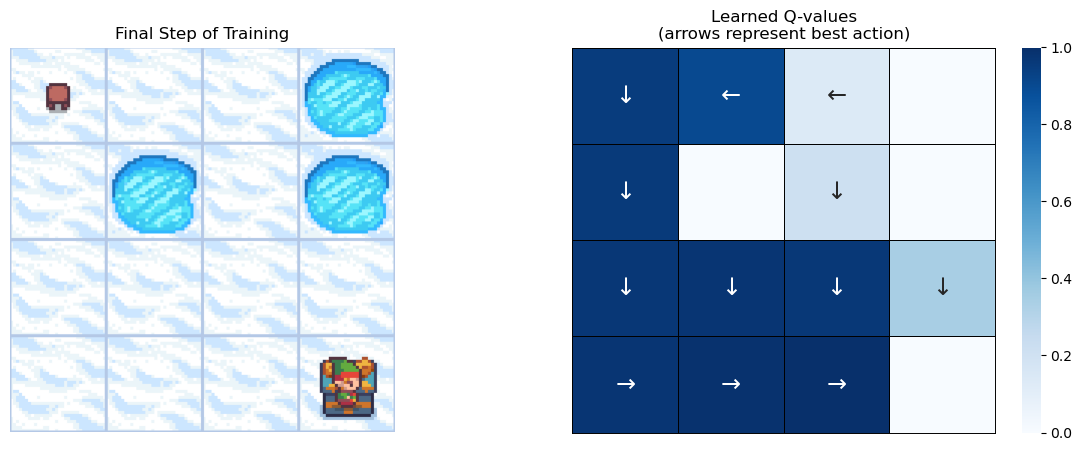

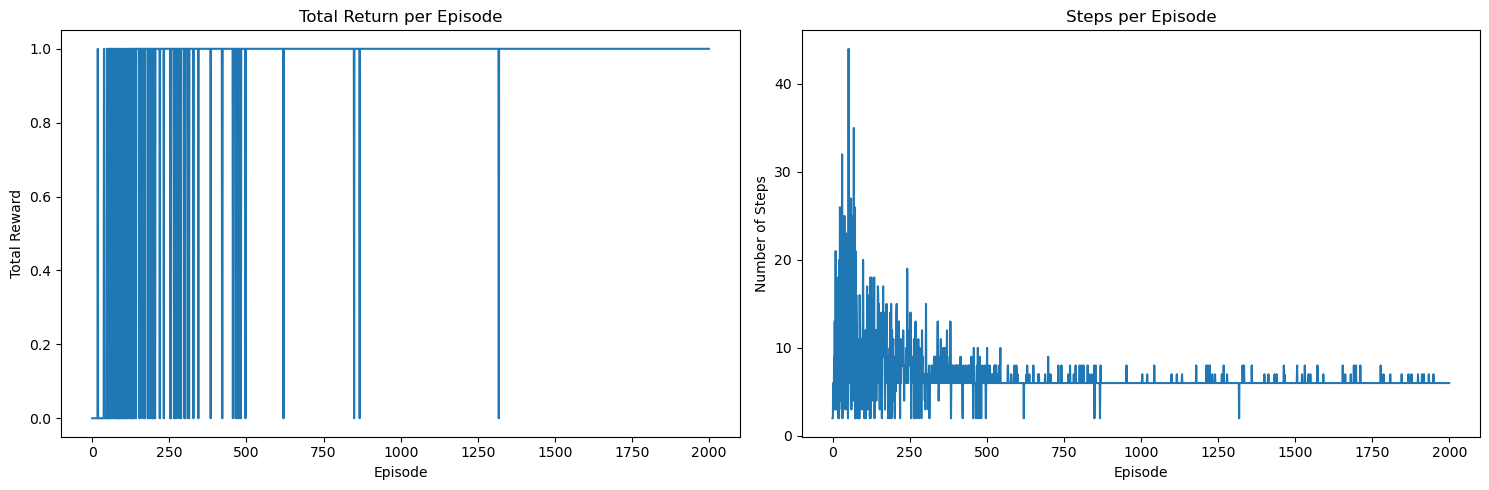

In [ ]:

plot_q_values_map(qtable, env, map_size, frame_title="Final Step of Training")
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axs[0].plot(rewards_all_episodes)
axs[0].set_title("Total Return per Episode")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Total Reward")
axs[1].plot(steps_all_episodes)
axs[1].set_title("Steps per Episode")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Number of Steps")
plt.tight_layout()
plt.show()


## Evaluation
Below, we evaluate the Q-table performance by setting `epsilon = 0` (i.e., only exploit) and removing the Q-table update code.

Evaluation completed:
Total reward: 1.0
Steps taken: 6


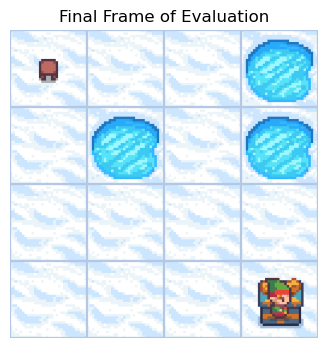

In [ ]:

state, info = env.reset()
done = False
total_reward_eval = 0
steps_eval = 0


frames = []

while not done:

    action = np.argmax(qtable[state])
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    total_reward_eval += reward
    steps_eval += 1
    frames.append(env.render())
    state = next_state
print("Evaluation completed:")
print(f"Total reward: {total_reward_eval}")
print(f"Steps taken: {steps_eval}")
plt.figure(figsize=(4, 4))
plt.imshow(frames[-1])
plt.title("Final Frame of Evaluation")
plt.axis("off")
plt.show()





